In [1]:
import os
import glob
import geemap
import ee, datetime
from IPython.display import Image
import pandas as pd
import geopandas as gpd
from pylab import *
import seaborn as sns
import rasterio
import folium
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt
from ipyleaflet import Map, basemaps, basemap_to_tiles, ImageOverlay

In [2]:
# Setting up Google Earth Engine (GEE)
# Getting tokens and activate EE
ee.Authenticate()

# Start up this session
ee.Initialize()

Enter verification code: 4/1AWtgzh43XolBFUuBb2-Dkl7eU13aUp_UYBJqkb4XyHtiozkWC3a8n1k5XWA

Successfully saved authorization token.


## Masking clouds

### Sentinel 2

In [3]:
# Using QA band to filter clouds
def maskS2clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cirrusBitMask).eq(0)
  mask3 = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cirrusBitMask).eq(0)

  return image.updateMask(mask).updateMask(mask2)

### Landsat 8

In [4]:
def maskL8clouds(image):
  qa = image.select('SR_QA_AEROSOL')

  # Bits 3 and 5 are clouds and cloud shadows.
  cloudBitMask = 1 << 3
  cloudShadowBitMask = 1 << 5

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
  mask3 = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cloudShadowBitMask).eq(0)

  return image.updateMask(mask).updateMask(mask2)

### Landsat 7

In [5]:
def maskL7clouds(image):
  qa = image.select('SR_CLOUD_QA')

  # Bits 4 and 6 are clouds and cloud shadows.
  cloudBitMask = 1 << 4
  cloudShadowBitMask = 1 << 6

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
  mask3 = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cloudShadowBitMask).eq(0)

  return image.updateMask(mask).updateMask(mask2)

# NDVI Bands Setup

### Sentinel 2

In [6]:
# NDVI for Sentine 2 bands
def senNDVI(image):
    return image.normalizedDifference(['B8', 'B4'])

### Landsat 8

In [7]:
# NDVI for Landsat 8 bands
def l8NDVI(image):
    return image.normalizedDifference(['SR_B5', 'SR_B4'])

### Landsat 7

In [8]:
# NDVI for Landsat 7 bands
def l7NDVI(image):
    return image.normalizedDifference(['SR_B4', 'SR_B3'])

# Set study area

In [9]:
# Rim Fire, CA
coords = [-120.083, 37.850]

# Create earth engine point
point = {'type':'Point', 'coordinates':coords}

# Time Period: Before Fire and its NDVI Analysis

In [10]:
# Set start and end date
startTime = datetime.datetime(2011, 1, 1)
endTime = datetime.datetime(2012, 10, 30)

# Getting L7 image collection
collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterDate(startTime, endTime).filterBounds(point)

# Limit the collection to the 1 most recent images.
recent = collection.sort('system:time_start', False).limit(1)
# Pull the image from the collection
image = recent.first()
print('Recent images: ' + str(recent.getInfo()) + '\n')

Recent images: {'type': 'ImageCollection', 'bands': [], 'id': 'LANDSAT/LE07/C02/T1_L2', 'version': 1678840857245417, 'properties': {'date_range': [915148800000, 1649203200000], 'visualization_2_bands': 'SR_B7,SR_B4,SR_B2', 'visualization_2_name': 'Shortwave Infrared (742)', 'period': 0, 'type_name': 'ImageCollection', 'keywords': ['cfmask', 'cloud', 'etm', 'fmask', 'global', 'landsat', 'lasrc', 'lst', 'reflectance', 'sr', 'usgs'], 'visualization_1_bands': 'SR_B4,SR_B3,SR_B2', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_2_gain': '1.8,1.9,1.9', 'description': '<p>This dataset contains atmospherically corrected\nsurface reflectance and land surface temperature derived from the data\nproduced by the Landsat 7 ETM+ sensor.\nThese images contain 4 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and one thermal infrared (TIR) band processed to orthorectified\nsurface tempe

In [11]:
# Set the visualization parameters for the output
visParams = {'bands': ['SR_B3', 'SR_B2', 'SR_B1'], 'dimensions': 1000}

# Create image thumbnail in earth engine and view
thumbnail = image.getThumbUrl(visParams)
Image(url = thumbnail)

In [12]:
# Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
x = date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2012-10-07 11:35:32.109000


In [13]:
# Get a list of all metadata properties
properties = collection.propertyNames()
print('Metadata properties: '+str(properties.getInfo())) 

Metadata properties: ['date_range', 'visualization_2_bands', 'visualization_2_name', 'period', 'type_name', 'keywords', 'visualization_1_bands', 'thumb', 'visualization_2_gain', 'description', 'source_tags', 'visualization_1_name', 'system:id', 'provider_url', 'title', 'visualization_0_gain', 'sample', 'tags', 'product_tags', 'visualization_1_gain', 'provider', 'system:version', 'visualization_0_name', 'visualization_0_bands']


In [14]:
# Get the 'WRS_ROW' location identifier
target_row = 'WRS_ROW'
meta_row = image.get(target_row).getInfo()
print(f'{target_row} = {meta_row}')

# Get the 'WRS_PATH' location identifier
target_path = 'WRS_PATH'
meta_path = image.get(target_path).getInfo()
print(f'{target_path} = {meta_path}')

# List of data fields in the image
properties = image.propertyNames()
print('Metadata properties: '+str(properties.getInfo())) 

# Get the scene id
target = 'LANDSAT_SCENE_ID'
meta = image.get(target).getInfo()
print(f'{target} = {meta}')

WRS_ROW = 34
WRS_PATH = 43
Metadata properties: ['IMAGE_QUALITY', 'WRS_TYPE', 'system:id', 'CORRECTION_GAIN_BAND_6_VCID_2', 'CORRECTION_GAIN_BAND_6_VCID_1', 'CORRECTION_GAIN_BAND_2', 'CORRECTION_GAIN_BAND_1', 'TEMPERATURE_ADD_BAND_ST_B6', 'system:footprint', 'REFLECTIVE_SAMPLES', 'TEMPERATURE_MINIMUM_BAND_ST_B6', 'CORRECTION_GAIN_BAND_8', 'CORRECTION_GAIN_BAND_7', 'CORRECTION_GAIN_BAND_5', 'SUN_AZIMUTH', 'CORRECTION_GAIN_BAND_4', 'CORRECTION_GAIN_BAND_3', 'GAIN_CHANGE_BAND_7', 'GAIN_CHANGE_BAND_8', 'GAIN_CHANGE_BAND_5', 'DATE_ACQUIRED', 'GAIN_CHANGE_BAND_3', 'ELLIPSOID', 'GAIN_CHANGE_BAND_4', 'GAIN_CHANGE_BAND_1', 'GAIN_CHANGE_BAND_2', 'SENSOR_MODE', 'STATION_ID', 'DATA_SOURCE_REANALYSIS', 'ORIENTATION', 'WRS_ROW', 'GAIN_BAND_6_VCID_2', 'GAIN_BAND_6_VCID_1', 'CLOUD_COVER', 'COLLECTION_CATEGORY', 'GRID_CELL_SIZE_REFLECTIVE', 'ALGORITHM_SOURCE_SURFACE_TEMPERATURE', 'CLOUD_COVER_LAND', 'GEOMETRIC_RMSE_MODEL', 'COLLECTION_NUMBER', 'DATA_SOURCE_WATER_VAPOR', 'LANDSAT_SCENE_ID', 'WRS_PATH', 

In [15]:
# Estimating the cloud cover
target = 'CLOUD_COVER'
meta = image.get(target).getInfo()
print(f'{target} = {meta}')

CLOUD_COVER = 0


#### Calculating NDVI

In [16]:
# Run the Landsat 7 NDVI function
l7ndvi = l7NDVI(image)

# Change visualization setting for the NDVI data
visParams = {'min':0, 'max': 1, 'dimensions':1000}
thumbnail = l7ndvi.getThumbUrl(visParams)
Image(url=thumbnail)

#### Interactive NDVI graph

In [17]:
# Visualization settings
rgbParams = {'bands': ['SR_B3', 'SR_B2', 'SR_B1'], 'gamma': [1.4, 1.2, 1.4]}
ndviParams = {'min':0, 'max': 1}

# Create the map
Map = geemap.Map(location=coords[::-1], zoom = 11)

# Add a marker to show the location
Map.add_marker(coords[::-1])

# Add the Landsat 7 image to the map
Map.addLayer(image, rgbParams, 'Natural Color Landsat 7');

# Add the NDVI image to the map
Map.addLayer(l7ndvi, ndviParams, 'NDVI')

# Add layer control
Map.addLayerControl()

# Display the map
Map

Map(center=[37.85, -120.083], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

# Time Period: During Fire and its NDVI Analysis¶

In [18]:
# Set start and end date
startTime = datetime.datetime(2013,11,15)
endTime = datetime.datetime(2014,1,30)

# Get the Landsat 8 image collection
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(point)

# Limit the collection to the 1 most recent images within the time range.
recent = collection.filterDate(startTime, endTime).sort('system:time_start', False).limit(1)

# Pull the image from the collection
image = recent.first()

print('Recent images: ' + str(recent.getInfo()) + '\n')

Recent images: {'type': 'ImageCollection', 'bands': [], 'id': 'LANDSAT/LC08/C02/T1_L2', 'version': 1677795896637188, 'properties': {'type_name': 'ImageCollection', 'keywords': ['cfmask', 'cloud', 'fmask', 'global', 'l8sr', 'landsat', 'lasrc', 'lst', 'reflectance', 'sr', 'usgs'], 'visualization_1_bands': 'SR_B5,SR_B4,SR_B3', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_1_max': '30000.0', 'description': '<p>This dataset contains atmospherically corrected\nsurface reflectance and land surface temperature derived from the data\nproduced by the Landsat 8 OLI/TIRS sensors.\nThese images contain 5 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and one thermal infrared (TIR) band processed to orthorectified\nsurface temperature. They also contain intermediate bands used in\ncalculation of the ST products, as well as QA bands.</p><p>Landsat 8 SR products are created with the

In [19]:
# Define the visualization parameters
visParams = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'dimensions': 1000}

# Create a thumbnail from the image
thumbnail = image.getThumbUrl(visParams)

# Display the image
Image(url=thumbnail)

In [20]:
# Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
x = date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2014-01-22 10:41:02.082000


In [21]:
# Estimating the cloud cover
target = 'CLOUD_COVER'
meta = image.get(target).getInfo()
print(f'{target} = {meta}')

CLOUD_COVER = 1.48


#### Calculating NDVI

In [22]:
# Run the Landsat 8 NDVI function
l8ndvi = l8NDVI(image)

# Change visualization setting for the NDVI data
visParams = {'min':0, 'max': 1, 'dimensions':1000}
thumbnail = l8ndvi.getThumbUrl(visParams)
Image(url = thumbnail)

#### Interactive NDVI graph

In [23]:
# Visualization settings
rgbParams = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'max': 3000, 'gamma': [1.4, 1.2, 1.4]}
ndviParams = {'min':0, 'max': 1}

# Create the map
Map = geemap.Map(location = coords[::-1], zoom = 10)

# Add a marker to show the location
Map.add_marker(coords[::-1])

# Add the Landsat 8 image to the map
Map.addLayer(image, rgbParams, 'Natural Color Landsat 8');

# Add the NDVI image to the map
Map.addLayer(l8ndvi, ndviParams, 'NDVI')

# Add layer control
Map.addLayerControl()

# Display the map
Map

Map(center=[37.85, -120.083], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

# Time Period: After Fire and its NDVI Analysis¶

In [24]:
# Set start and end date
startTime = datetime.datetime(2015, 7, 1)
endTime = datetime.datetime.now()

# Create Sentinel-2 image collection
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(startTime, endTime).filterBounds(point)

# Limit the collection to the 1 most recent images.
recent = collection.sort('system:time_start', False).limit(1)
# Pull the image from the collection
image = recent.first()

print('Recent images: ' + str(recent.getInfo()) + '\n')

Recent images: {'type': 'ImageCollection', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B8', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B8A', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B9', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id':

In [25]:
# Set the visualization parameters for the output
visParams = {'bands': ['B4', 'B3', 'B2'], 'max': 2500, 'dimensions':1000 }

# Create image thumbnail in earth engine and view
thumbnail = image.getThumbUrl(visParams)
Image(url = thumbnail)

In [26]:
# Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
x = date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2023-03-12 11:54:10.914000


In [27]:
sorted = collection.sort('CLOUD_COVERAGE_ASSESSMENT').limit(10)

# Get the first (least cloudy) image.
image = sorted.first();

#Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
# print(date['value'])
x = date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2022-09-16 12:04:00.890000


In [28]:
# Define the visualization parameters
visParams = {'bands': ['B4', 'B3', 'B2'], 'max': 2500, 'dimensions': 1000}

# Create a thumbnail from the image
thumbnail = image.getThumbUrl(visParams)

# Display the image
Image(url=thumbnail)

In [29]:
# Estimating the cloud cover
target = 'CLOUD_COVERAGE_ASSESSMENT'
meta = image.get(target).getInfo()
print(f'{target} = {meta}')

CLOUD_COVERAGE_ASSESSMENT = 0


#### Calculating NDVI

In [30]:
# Run the sentinel NDVI function
sndvi = senNDVI(image)

# visualizing the NDVI data
visParams = {'min':0, 'max': 1, 'dimensions':1000}
thumbnail = sndvi.getThumbUrl(visParams)
Image(url=thumbnail)

#### Interactive NDVI graph

In [31]:
# Visualization settings
rgbParams = {'bands': ['B4', 'B3', 'B2'], 'max': 2500, 'gamma': [1.4, 1.2, 1.4]}
ndviParams = {'min':0, 'max': 1}

# Create the map
Map = geemap.Map(location = coords[::-1], zoom = 12)

# Add a marker to show the location
Map.add_marker(coords[::-1])

# Add the Landsat 8 image to the map
Map.addLayer(image, rgbParams, 'Natural Color Sentinel 2');

# Add the NDVI image to the map
Map.addLayer(sndvi, ndviParams, 'NDVI')

# Add layer control
Map.addLayerControl()

# Display the map
Map

Map(center=[37.85, -120.083], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

# Time Series overview

In [32]:
# Set start and end date
startTime = datetime.datetime(2015, 6, 1)
endTime = datetime.datetime.now()

# Create Sentinel-2 image collection
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(startTime, endTime).filterBounds(point)

info = collection.getRegion(point,10).getInfo()

# Apply the cloud mask to the collection
maskeddata = collection.map(maskS2clouds)

# Get the data for a specific area
info_filter = maskeddata.getRegion(point,10).getInfo()

### Unfiltered Data Sentinel 2

Text(0.5, 1.0, 'NDVI')

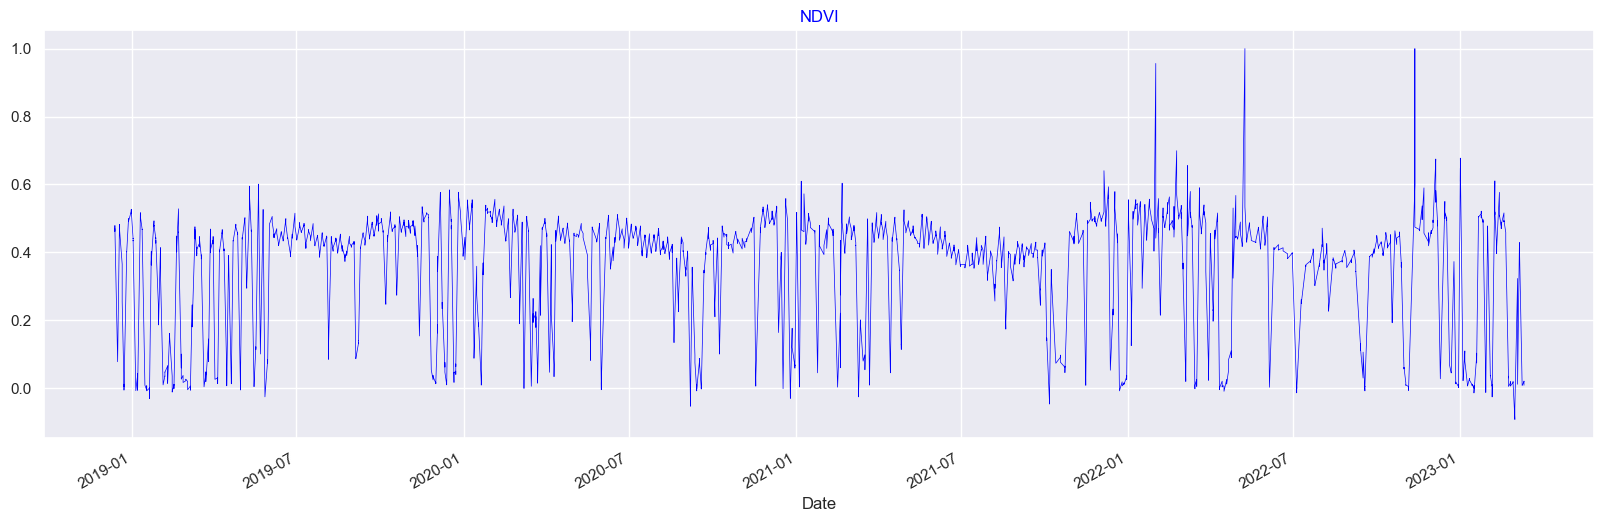

In [33]:
# Plot the ndvi
data = info

# Reshape image collection 
header = data[0]
data = np.array(data[1:])

iTime = header.index('time')
timestamp = data[0:,iTime].astype(np.int64) / 1000
time = [datetime.datetime.fromtimestamp(i) for i in timestamp]

# List of used image bands
band_list = ['B4','B8']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# reshape NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df['NDVI'].plot(linewidth=0.5, color="blue")
plt.title('NDVI', color ="blue")

### Filtered Data Sentinel 2

Text(0.5, 1.0, 'NDVI')

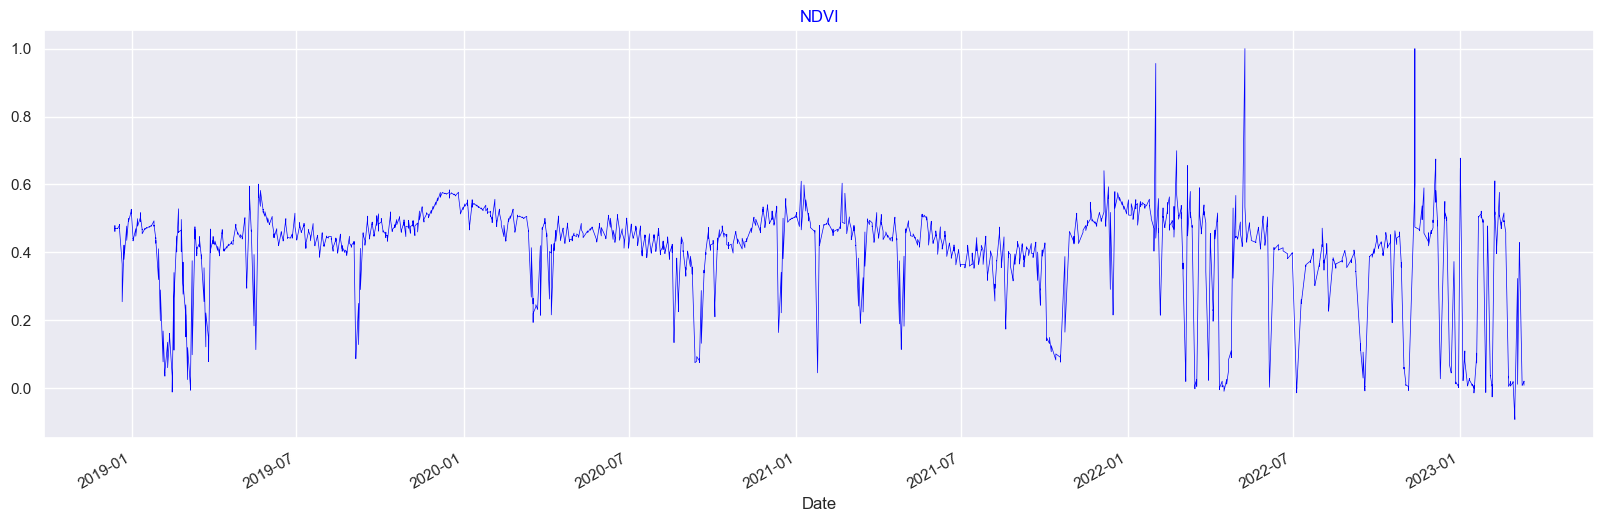

In [34]:
# Plot the ndvi
data = info_filter

# Reshape image collection 
header = data[0]
data = np.array(data[1:])

iTime = header.index('time')
timestamp = data[0:,iTime].astype(np.int64) / 1000
time = [datetime.datetime.fromtimestamp(i) for i in timestamp]

# List of used image bands
band_list = ['B4','B8']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# reshape NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df['NDVI'].plot(linewidth=0.5, color="blue")
plt.title('NDVI', color ="blue")

### Unfiltered Data Landsat 7

In [35]:
# Set start and end date
startTime = datetime.datetime(2010, 1, 1)
endTime = datetime.datetime(2015, 12, 31)

# Getting L7 image collection
collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterDate(startTime, endTime).filterBounds(point)

info = collection.getRegion(point, 10).getInfo()

# Apply the cloud mask to the collection
maskeddata = collection.map(maskL7clouds)

# Get the data for a specific area
info_filter = maskeddata.getRegion(point, 10).getInfo()

Text(0.5, 1.0, 'NDVI')

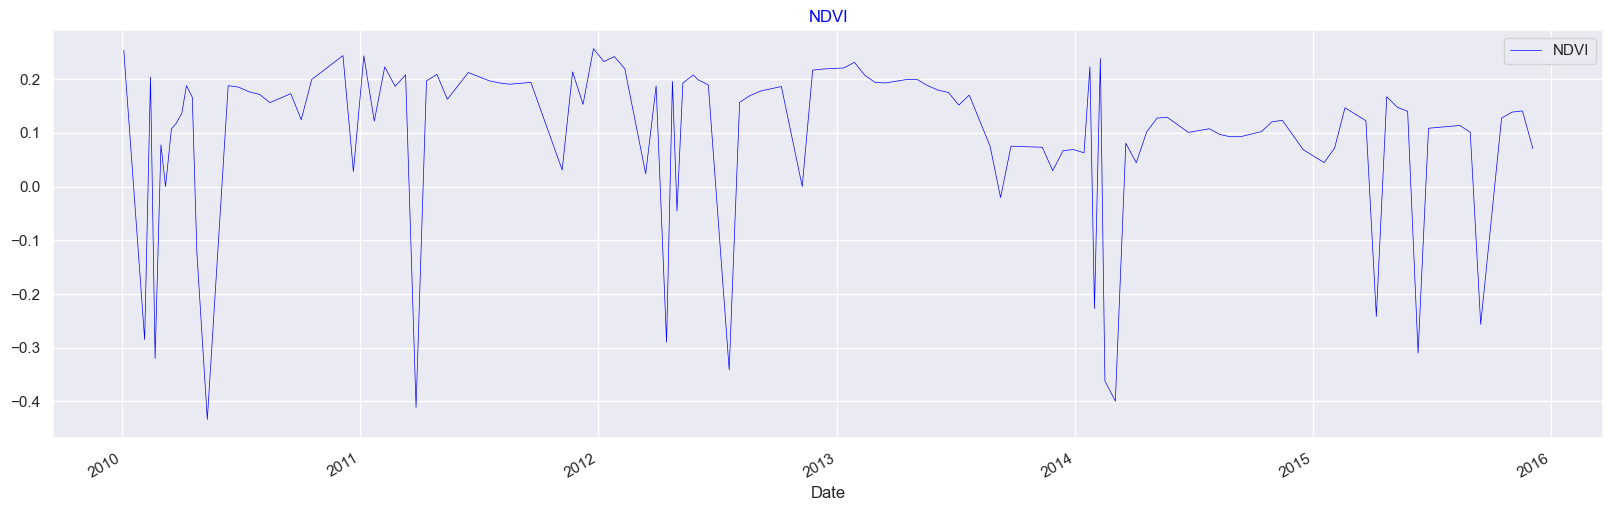

In [36]:
# Plot the ndvi
data = info

# Reshape image collection 
header = data[0]
data = np.array(data[1:])

iTime = header.index('time')
timestamp = data[0:,iTime].astype(np.int64) / 1000
time = [datetime.datetime.fromtimestamp(i) for i in timestamp]

# List of used image bands
band_list = ['SR_B3','SR_B4']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# reshape NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df.plot(x='Date', y='NDVI', linewidth=0.5, color="blue")
plt.title('NDVI', color ="blue")


### Filtered Data Landsat 7

Text(0.5, 1.0, 'NDVI')

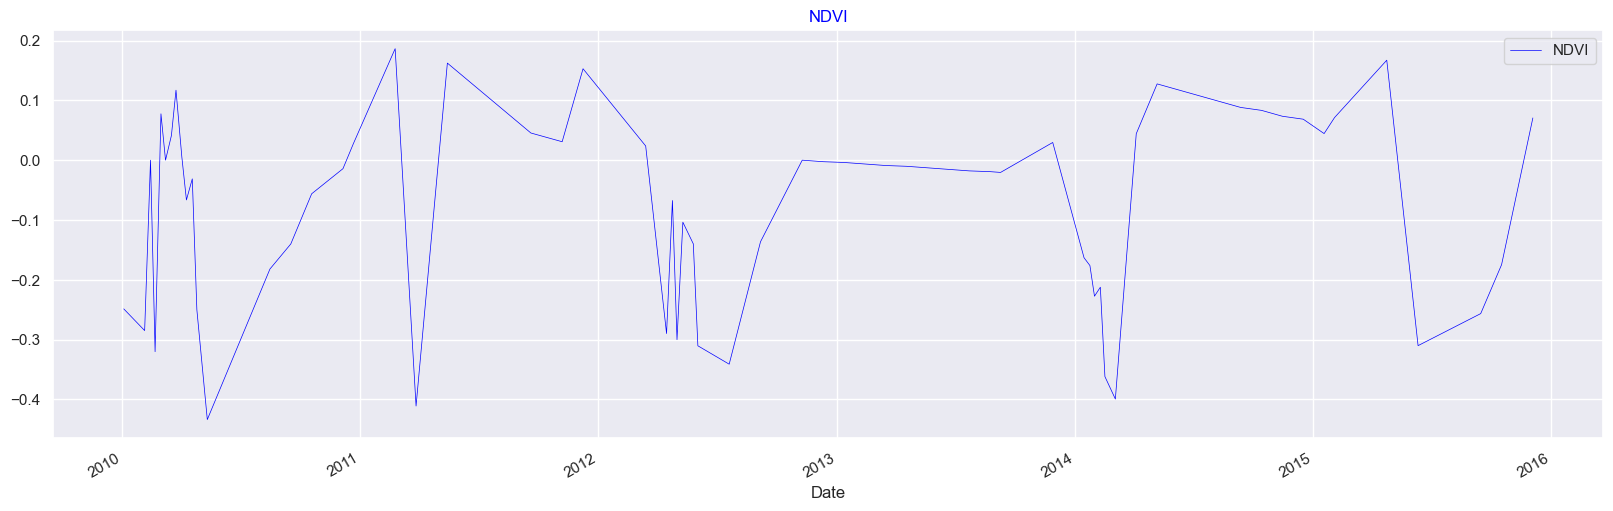

In [37]:
# Plot the ndvi
data = info_filter

# Reshape image collection 
header = data[0]
data = np.array(data[1:])

iTime = header.index('time')
timestamp = data[0:,iTime].astype(np.int64) / 1000
time = [datetime.datetime.fromtimestamp(i) for i in timestamp]

# List of used image bands
band_list = ['SR_B3','SR_B4']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# reshape NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df.plot(x='Date', y='NDVI', linewidth=0.5, color="blue")
plt.title('NDVI', color ="blue")
